# Cross-Entropy Method

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

env = gym.make('CartPole-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


### 2. Instantiate the Environment and Agent

In [3]:
class Agent(nn.Module):
    
    def __init__(self, env, h_size=16, action_space=2):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = action_space
        
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size  #h_size will be for a bias weight
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))  # fc1 weight
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])   # bias for fc1
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            # contvert to the discrete action space we have
            action = np.argmax(action.cpu().numpy())
            #print(action)
            state, reward, done, _ = self.env.step(action)
            #self.env.render()
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

### 3. Train the Agent with the Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

1
2
3
4
5
6
7
8
9
10
Episode 10	Average Score: 60.70
11
12
13
14
15
16
17
18
19
20
Episode 20	Average Score: 107.00
21
22
23
24
25
26
27
28
29
30
Episode 30	Average Score: 138.00
31
32
33
34
35
36
37
38
39
40
Episode 40	Average Score: 153.50
41
42
43
44
45
46
47
48
49
50
Episode 50	Average Score: 162.80
51
52
53
54
55
56
57
58
59
60
Episode 60	Average Score: 169.00
61
62
63
64
65
66
67
68
69
70
Episode 70	Average Score: 173.43
71
72
73
74
75
76
77
78
79
80
Episode 80	Average Score: 176.75
81
82
83
84
85
86
87
88
89
90
Episode 90	Average Score: 179.33
91
92
93
94
95
96
97
98
99
100
Episode 100	Average Score: 181.40
101
102
103
104
105
106
107
108
109

Environment solved in 9 iterations!	Average Score: 195.10


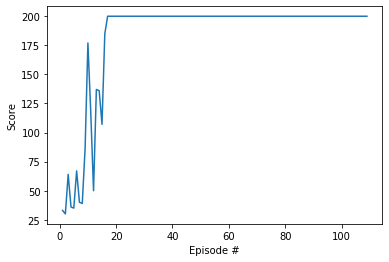

In [4]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        
        print(i_iteration)
        
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            torch.save(agent.state_dict(), 'checkpoint_car.pth')

        if np.mean(scores_deque)>=195.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            torch.save(agent.state_dict(), 'checkpoint_car.pth')
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [9]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint_car.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
        action = np.argmax(action.cpu().numpy())
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        print(reward)
        break

env.close()

1.0
